In [1]:
import elecboltz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# matplotlib settings
# reset defaults
mpl.rcdefaults()
# font
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['pdf.fonttype'] = 3
# plotting
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 20

In [3]:
init_params = {
    'a': 3.75,
    'b': 3.75,
    'c': 13.2,
    'energy_scale': 160,
    'band_params': {'mu': -0.82439881, 't': 1, 'tp':-0.13642799,
                    'tpp': 0.06816836, 'tz': 0.06512192},
    'domain_size': [1.0, 1.0, 2.0],
    'periodic': 2,
    'scattering_models': ['isotropic', 'cos2phi'],
    'scattering_params': {'gamma_0': 12, 'gamma_k': 60, 'power': 12},
    'resolution': 41,
}

In [4]:
bounds = {
    'scattering_params': {
        'gamma_0': (5, 20),
        'gamma_k': (10, 200),
        'power': (1, 20)
    },
}

In [5]:
phis = [0, 15, 30, 45]
n_interp = 35

loader = elecboltz.Loader(x_vary_label='theta', y_label='rho_zz',
                          x_search={'phi': phis.copy(), 'H': [45] * 4})
loader.load("../data/ADMR_NdLSCO", "NdLSCO_0p25_rho_c-vs-theta_25K_",
            x_columns=[0], y_columns=[1])
loader.interpolate(n_interp, x_normalize=0)

In [22]:
elecboltz.fit_model(
    loader.x_data, loader.y_data, init_params=init_params, bounds=bounds,
    x_normalize={'Btheta': 0}, save_path="../fits", save_label="NdLSCO_25K",
    workers=-1)

/users/eleves-a/2024/saleh.shamloo-ahmadi.m1/elecBoltz/.venv/lib64/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Iteration 1
-----------
Best Parameters:
{'scattering_params': {'gamma_0': np.float64(13.81487818359634),
                       'gamma_k': np.float64(103.31162314470936),
                       'power': np.float64(9.58020642004165)}}
Convergence: 0.00900

Iteration Runtime: 39.392 seconds
Total Runtime: 39.4 seconds

Iteration 2
-----------
Best Parameters:
{'scattering_params': {'gamma_0': np.float64(13.81487818359634),
                       'gamma_k': np.float64(103.31162314470936),
                       'power': np.float64(9.58020642004165)}}
Convergence: 0.01302

Iteration Runtime: 19.994 seconds
Total Runtime: 59.4 seconds

Iteration 3
-----------
Best Parameters:
{'scattering_params': {'gamma_0': np.float64(13.81487818359634),
                       'gamma_k': np.float64(103.31162314470936),
                       'power': np.float64(9.58020642004165)}}
Convergence: 0.02073

Iteration Runtime: 19.506 seconds
Total Runtime: 1 minutes 18.9 seconds

Iteration 4
-----------
Best P

{'message': 'Optimization terminated successfully.',
 'success': True,
 'jac': [1.6960129812816414e-05,
  2.021691376212897e-06,
  1.3091132996380673e-05],
 'fit_params': {'scattering_params': {'gamma_0': 12.663478713551394,
   'gamma_k': 76.57397879494391,
   'power': 13.551370834057552}},
 'residual': 0.0019543843475215974,
 'evaluations': 593,
 'iterations': 12,
 'init_params': {'scattering_params': {'gamma_0': 12,
   'gamma_k': 60,
   'power': 12}},
 'fixed_params': {'resolution': 41,
  'band_params': {'tz': 0.06512192,
   'tp': -0.13642799,
   'mu': -0.82439881,
   'tpp': 0.06816836,
   't': 1},
  'c': 13.2,
  'domain_size': [1.0, 1.0, 2.0],
  'b': 3.75,
  'a': 3.75,
  'scattering_models': ['isotropic', 'cos2phi'],
  'periodic': 2,
  'energy_scale': 160},
 'begin_time': '2025-07-25T01:28:58.265374',
 'end_time': '2025-07-25T01:33:56.571274',
 'runtime': 298.3059}

In [6]:
params = elecboltz.easy_params({'load_fit': "../fits/NdLSCO_25K.json"})
rho_fem_zz = np.empty((len(phis), n_interp))

band = elecboltz.BandStructure(**params)
band.discretize()
cond = elecboltz.Conductivity(band, **params)

cond.Bamp = 45
for i, phi in enumerate(phis):
    cond.Bphi = phi
    for j, theta in enumerate(
            loader.x_data_interpolated['theta'][i]):
        cond.Btheta = theta
        cond.calculate()
        rho_fem = np.linalg.inv(cond.sigma)
        rho_fem_zz[i, j] = rho_fem[2, 2]

cond.Bphi = 0
cond.Btheta = 0
cond.calculate()
rho_fem = np.linalg.inv(cond.sigma)
rho_fem_zz_0 = rho_fem[2, 2]

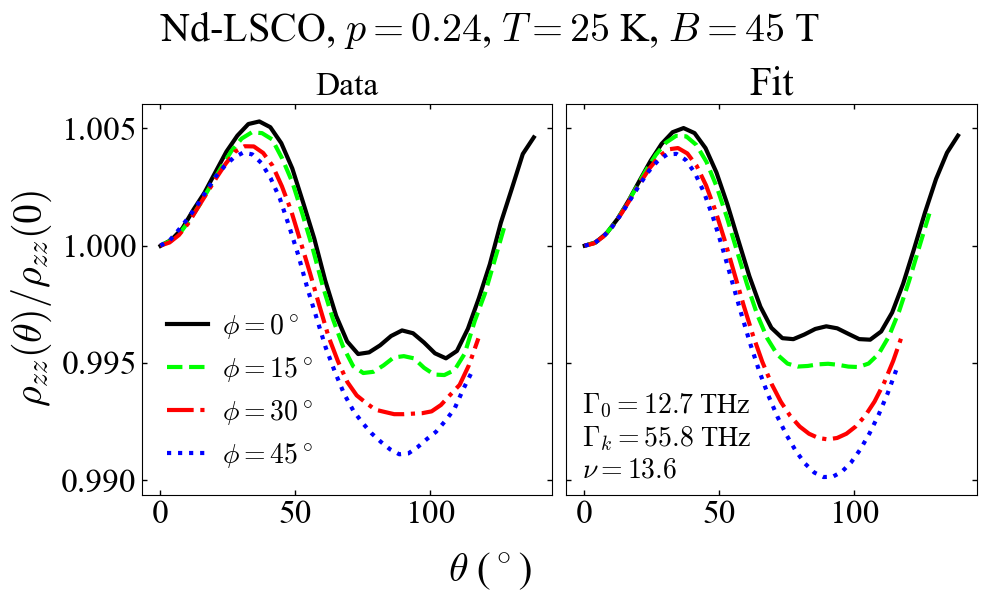

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (10, 6),
                        sharex=True, sharey=True)
palette = ['black', 'lime', 'red', 'blue']
styles = ['-', '--', '-.', ':']
for i, phi in enumerate(phis):
    color = palette[i]
    axs[0].plot(loader.x_data_interpolated['theta'][i],
                loader.y_data_interpolated['rho_zz'][i],
                label=rf"$\phi={phi}^\circ$", color=palette[i],
                linestyle=styles[i])
    axs[1].plot(loader.x_data_interpolated['theta'][i],
                rho_fem_zz[i, :] / rho_fem_zz_0,
                label=rf"$\phi={phi}^\circ$", color=palette[i],
                linestyle=styles[i])
fig.suptitle(fr"Nd-LSCO, $p=0.24$, $T=25$ K, $B=45$ T")
axs[0].set_title("Data", fontsize=24)
axs[1].set_title("Fit")
fig.supxlabel(r"$\theta$ ($^\circ$)")
fig.supylabel(r"$\rho_{zz}(\theta)/\rho_{zz}(0)$")
axs[0].legend(frameon=False, handlelength=1.5, handletextpad=0.5)
axs[1].text(0.04, 0.03,
            fr"$\Gamma_0 = {params['scattering_params']['gamma_0']:.3g}$"
            + " THz\n" +
            fr"$\Gamma_k = {params['scattering_params']['gamma_k']:.3g}$"
            + " THz\n" +
            fr"$\nu = {params['scattering_params']['power']:.3g}$",
            transform=axs[1].transAxes, va='bottom', ha='left',
            fontsize=20)
plt.tight_layout(pad=0.4)
plt.savefig("NdLSCO/Fit_ADMR_NdLSCO_T=25K_B=45T.pdf", bbox_inches='tight')
plt.show()